# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3945.639516,0.9999,-131.886217,1760.71,1628.823783
OMUSDT,526.319895,1698.698814,0.4305,0.000000,1172.38,1172.380000
BTCUSDT,601.021649,866.578011,0.2196,3.537078,265.56,269.097078
JASMYUSDT,387.458505,554.188507,0.1405,0.000000,166.73,166.730000
SOLUSDT,281.200518,390.388214,0.0989,0.000000,109.19,109.190000
ETHUSDT,250.747339,261.477776,0.0663,0.000000,10.73,10.730000
TRXUSDT,76.868953,129.550150,0.0328,-10.723889,52.68,41.956111
BBUSDT,60.176053,43.573085,0.0110,-39.733101,-16.60,-56.333101
BNBUSDT,1.142121,1.184953,0.0003,-10.606040,0.04,-10.566040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [19]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [20]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [21]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [22]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-04    -76.382206
2024-12-05    261.133085
2024-12-06     -9.697423
2024-12-07    -17.431069
2024-12-08    111.313093
Name: Total, Length: 77, dtype: float64

In [23]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

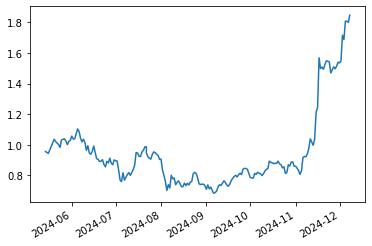

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3966
BNBUSDT,0.1669
PEPEUSDT,0.1583
TRXUSDT,0.0715
SUIUSDT,0.0692
XLMUSDT,0.0538
XRPUSDT,0.0447
JASMYUSDT,0.0389
ADAUSDT,0.0000
ALGOUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.382230
BTCUSDT,0.300000
PEPEUSDT,0.123407
TRXUSDT,0.061191
SUIUSDT,0.048760
XLMUSDT,0.038111
JASMYUSDT,0.030430
BNBUSDT,0.015871


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.369455
BTCUSDT,0.316272
TRXUSDT,0.210087
PEPEUSDT,0.104186


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1698.698814,0.430526,0.369455,0.061071
BTCUSDT,866.578011,0.219629,0.316272,-0.096643
JASMYUSDT,554.188507,0.140456,0.000000,0.000000
SOLUSDT,390.388214,0.098942,0.000000,0.000000
ETHUSDT,261.477776,0.066270,0.000000,0.000000
TRXUSDT,129.550150,0.032834,0.210087,-0.177253
BBUSDT,43.573085,0.011043,0.000000,0.000000
BNBUSDT,1.184953,0.000300,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.104186,-0.104186


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1698.698814,0.430526,0.382230,0.048296
BTCUSDT,866.578011,0.219629,0.300000,-0.080371
JASMYUSDT,554.188507,0.140456,0.030430,0.110026
SOLUSDT,390.388214,0.098942,0.000000,0.000000
ETHUSDT,261.477776,0.066270,0.000000,0.000000
TRXUSDT,129.550150,0.032834,0.061191,-0.028357
BBUSDT,43.573085,0.011043,0.000000,0.000000
BNBUSDT,1.184953,0.000300,0.015871,-0.015571
PEPEUSDT,0.000006,0.000000,0.123407,-0.123407
SUIUSDT,0.000000,0.000000,0.048760,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

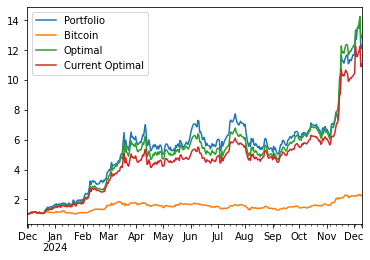

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

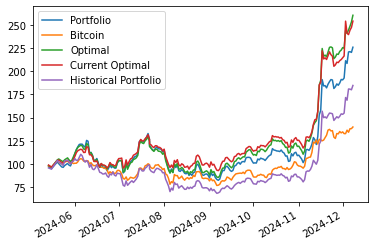

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-29,187.361562,134.971167,221.504108,211.491167,151.414174
2024-11-30,191.180417,133.506331,222.868434,212.688596,154.042164
2024-12-01,190.737188,134.578273,225.588771,214.624163,153.524639
2024-12-02,192.763205,132.703379,224.910293,216.552166,154.867822
2024-12-03,211.393426,132.715937,244.152924,254.157358,171.684779
2024-12-04,208.518312,136.453406,241.094464,240.995461,168.792541
2024-12-05,220.897120,134.162033,244.588316,239.631923,180.882889
2024-12-06,221.206994,137.975577,248.650758,244.356398,180.754476
2024-12-07,220.413967,138.101611,253.280917,247.384324,180.041463
2024-12-08,226.011384,139.857753,260.512316,254.186016,184.701345


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.661811
 dtype: float64,
 0.6626633243716237)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.645219
 dtype: float64,
 0.6452188366695693)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.709752
Bitcoin            0.435022
Optimal            0.662663
Current Optimal    0.630539
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.45681249172252536

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.025059,0.015871,0.001951,0.005405,0.000132,0.005273
BTCUSDT,0.376251,0.300000,0.032239,0.131101,0.038786,0.092315
JASMYUSDT,0.080216,0.030430,0.005275,0.021438,0.002657,0.018781
OMUSDT,18.429994,0.382230,0.896831,0.650239,0.547264,0.102975
PEPEUSDT,0.844958,0.123407,0.046165,0.130688,0.055728,0.074960
SUIUSDT,0.112536,0.048760,0.007689,0.028991,0.004920,0.024071
TRXUSDT,0.055760,0.061191,0.005575,0.017254,0.004092,0.013162
XLMUSDT,0.051557,0.038111,0.004275,0.014884,0.001986,0.012898


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.863898,0.369455,0.559250,0.602475,0.474642,0.127833
BTCUSDT,0.142267,0.316272,0.207919,0.138520,0.051533,0.086988
TRXUSDT,0.130283,0.210087,0.154337,0.157097,0.105487,0.051611
PEPEUSDT,0.068923,0.104186,0.078494,0.101907,0.039535,0.062372


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.005471,0.43,0.647452,0.638671,0.509383,0.129288
BTCUSDT,0.098962,0.22,0.143864,0.089404,0.019755,0.069649
JASMYUSDT,0.066244,0.14,0.093024,0.144995,0.055599,0.089395
SOLUSDT,0.024474,0.10,0.056142,0.071043,0.009979,0.061063
ETHUSDT,0.009087,0.07,0.035671,0.033370,0.003530,0.029840
TRXUSDT,0.018604,0.03,0.021922,0.011880,0.001704,0.010176
BBUSDT,-0.005735,0.01,0.001924,0.010638,0.000391,0.010246


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05265045086653524, -0.07789938216670221)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048151061812145776, -0.07441724519539683)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.016731
BTCUSDT     -0.011273
JASMYUSDT   -0.011370
SOLUSDT     -0.007623
ETHUSDT      0.001101
TRXUSDT     -0.001870
BBUSDT      -0.000124
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047891
Name: 2024-11-25 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.040710
BTCUSDT     -0.007590
JASMYUSDT   -0.012470
SOLUSDT     -0.006799
ETHUSDT     -0.002833
TRXUSDT     -0.000930
BBUSDT      -0.000875
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072207
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06866254889377087, -0.08800640353844896)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06685502017486236, -0.08568965147482102)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.058152691916509396, -0.07597901478649935)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06320913830924497, -0.07933098789778693)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.038033
BTCUSDT     -0.005717
JASMYUSDT   -0.009708
SOLUSDT     -0.004743
ETHUSDT     -0.002501
TRXUSDT     -0.000493
BBUSDT      -0.000846
Portfolio   -0.062040
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06078363492795306, -0.07896844986671149)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06243411250212031, -0.07993570884422362)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.038046
BTCUSDT     -0.006259
JASMYUSDT   -0.009067
SOLUSDT     -0.005252
ETHUSDT     -0.002255
TRXUSDT     -0.000667
BBUSDT      -0.000632
Portfolio   -0.062178
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06008801520524321, -0.07831559980087696)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06375435610472834, -0.08175343473120077)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039932
BTCUSDT     -0.006567
JASMYUSDT   -0.008844
SOLUSDT     -0.004658
ETHUSDT     -0.002103
TRXUSDT     -0.000752
BBUSDT      -0.000659
Portfolio   -0.063516
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10865804678626191, -0.1540069813214803)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10688821551270568, -0.15047120947070414)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.097575
BTCUSDT     -0.001671
JASMYUSDT   -0.007849
SOLUSDT     -0.001377
ETHUSDT     -0.000588
TRXUSDT      0.000695
BBUSDT       0.000267
Portfolio   -0.108098
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06957588054038225, -0.08783583420122514)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06904146707540453, -0.08667288430110251)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.046379
BTCUSDT     -0.005483
JASMYUSDT   -0.008748
SOLUSDT     -0.004412
ETHUSDT     -0.001942
TRXUSDT     -0.000835
BBUSDT      -0.000645
Portfolio   -0.068444
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056957,-0.094925,-0.083356,-0.026934
2024-01-15,-0.056957,-0.094924,-0.079804,0.016372
2024-01-16,-0.056957,-0.094827,-0.078723,0.045905
2024-01-17,-0.056957,-0.096595,-0.084495,-0.029029
2024-01-18,-0.056957,-0.099207,-0.086326,-0.039238
...,...,...,...,...
2024-12-06,-0.047705,-0.118502,-0.093189,0.016609
2024-12-07,-0.047705,-0.118334,-0.095592,0.018621
2024-12-08,-0.047705,-0.117340,-0.092113,0.028551
2024-12-09,-0.088009,-0.129449,-0.108719,-0.102736


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034152,-0.084996,-0.081509,-0.017632
2024-05-29,-0.034152,-0.082329,-0.077146,-0.008918
2024-05-30,-0.034152,-0.072422,-0.068158,0.039622
2024-05-31,-0.034152,-0.073307,-0.062753,0.038617
2024-06-01,-0.034152,-0.076621,-0.067065,0.052272
...,...,...,...,...
2024-12-06,-0.043090,-0.075336,-0.065063,0.001403
2024-12-07,-0.043090,-0.075887,-0.064468,-0.003585
2024-12-08,-0.043090,-0.076390,-0.065419,0.025395
2024-12-09,-0.113315,-0.111785,-0.111554,-0.123966


<AxesSubplot:>

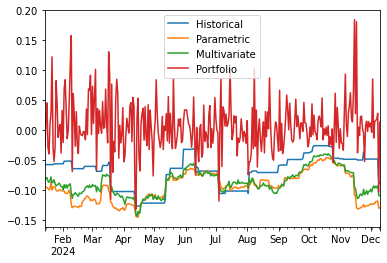

In [79]:
var_data.plot()

<AxesSubplot:>

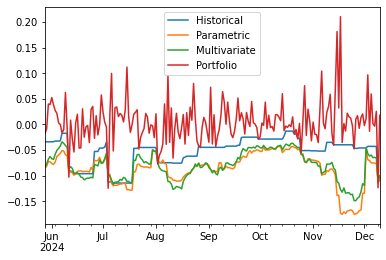

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024096,0.006024,0.012048
Kupiec Stat,5.753015,21.400625,14.311922
P-value,0.01646,0.000004,0.000155


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.06599,0.020305,0.020305
Kupiec Stat,0.967744,4.671569,4.671569
P-value,0.325243,0.030666,0.030666


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77217396, 0.0747166 , 0.05939486, 0.05276722, 0.04094736])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014801
ADAUSDT     0.015331
ALGOUSDT    0.017306
APTUSDT     0.016023
ARBUSDT     0.016817
              ...   
WBTCUSDT    0.009335
WLDUSDT     0.022039
XLMUSDT     0.012341
XRPUSDT     0.010803
XTZUSDT     0.016167
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

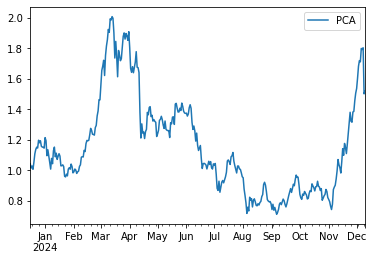

In [85]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

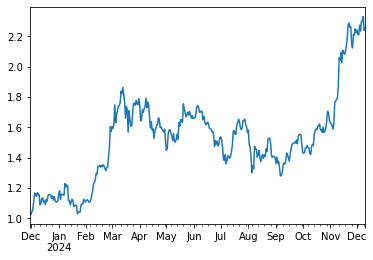

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.412922
WBETHUSDT    0.425134
ETHUSDT      0.425149
EGLDUSDT     0.425601
               ...   
FLOKIUSDT    1.120994
BONKUSDT     1.125956
WLDUSDT      1.132255
PEPEUSDT     1.177353
OMUSDT       1.521740
Length: 64, dtype: float64

<AxesSubplot:>

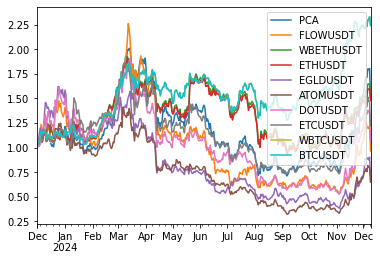

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

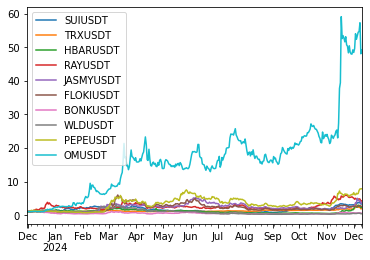

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53180669, 0.15328703, 0.13556311, 0.10236972, 0.07697344])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.105631
BTCUSDT      0.061473
JASMYUSDT    0.165518
SOLUSDT      0.101718
ETHUSDT      0.082562
TRXUSDT      0.049355
BBUSDT       0.212354
BNBUSDT      0.067297
PEPEUSDT     0.154092
Name: PC1, dtype: float64

<AxesSubplot:>

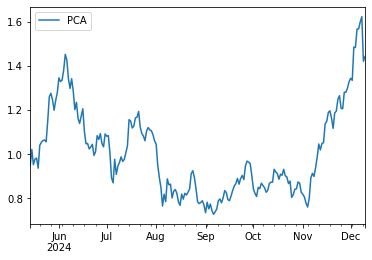

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

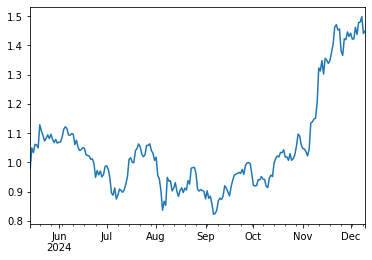

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.382550
ETHUSDT      0.403589
BNBUSDT      0.408148
BTCUSDT      0.421820
JASMYUSDT    0.640299
PEPEUSDT     0.703173
BBUSDT       0.714668
OMUSDT       0.859245
TRXUSDT      0.874339
dtype: float64

<AxesSubplot:>

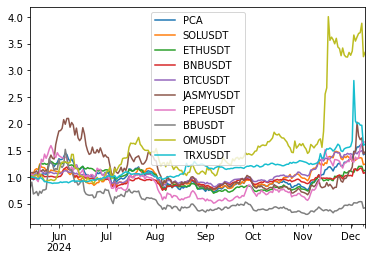

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.896215
BBUSDT       1.556935
JASMYUSDT    1.231651
SOLUSDT      1.145728
BTCUSDT      1.000000
ETHUSDT      0.955451
OMUSDT       0.893502
BNBUSDT      0.659953
TRXUSDT      0.263890
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.035128
ETHUSDT      1.743265
PEPEUSDT     1.497697
BNBUSDT      1.065265
SOLUSDT      1.053427
BTCUSDT      1.000000
OMUSDT       0.556774
TRXUSDT      0.047561
JASMYUSDT   -0.354669
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [98]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [99]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.700360
BBUSDT,0.441346
ETHUSDT,0.222079
JASMYUSDT,0.124877
OMUSDT,0.086266
TRXUSDT,0.016646
PEPEUSDT,-0.008291
BNBUSDT,-0.020839
SOLUSDT,-0.418352


### Regression to PCA

In [100]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.2502396489519144

In [101]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.245153
BNBUSDT      1.099791
PCA          1.000000
ETHUSDT      0.954833
SOLUSDT      0.789993
JASMYUSDT    0.404423
PEPEUSDT     0.364004
BBUSDT       0.345946
OMUSDT       0.237649
TRXUSDT      0.181081
dtype: float64

In [102]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.758134
SOLUSDT      1.073517
PCA          1.000000
ETHUSDT      0.896977
BNBUSDT      0.772898
OMUSDT       0.714901
BBUSDT       0.638261
JASMYUSDT    0.156673
TRXUSDT      0.109216
PEPEUSDT     0.027237
dtype: float64

### Correlation Matrix

<AxesSubplot:>

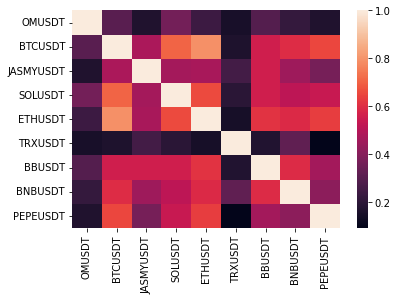

In [103]:
sns.heatmap(ex_ante_perf.corr())

<AxesSubplot:>

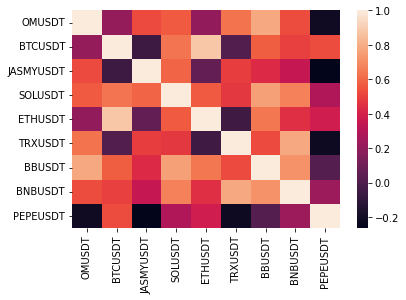

In [104]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr())

## Sliding window optimization

In [105]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [106]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-06-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-07-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948311,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-08-02,0.614341,0.053671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.325820,0.0
2024-09-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.982006,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-31,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664610,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-11-30,0.000000,0.044675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0347,0.182972,0.0
2024-12-10,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0


In [107]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

PEPEUSDT     0.591560
HBARUSDT     0.144255
CRVUSDT      0.135383
JASMYUSDT    0.128802
SEIUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
ICPUSDT      0.000000
IMXUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-10 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

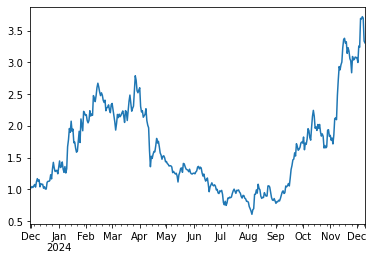

In [108]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()